<IPython.core.display.Javascript object>


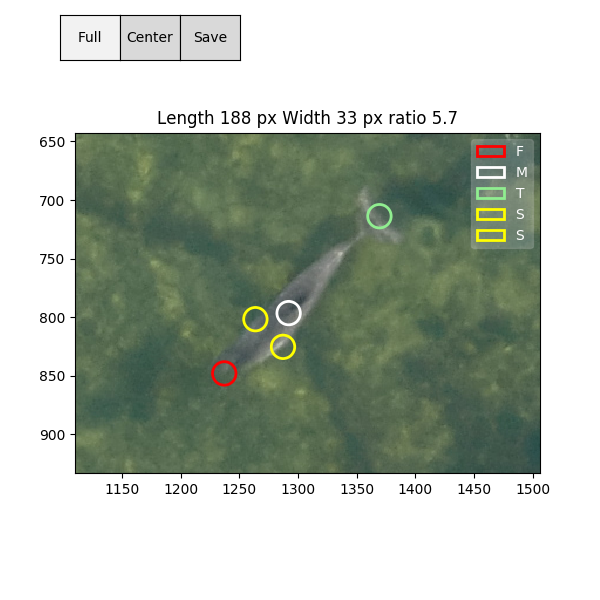

In [9]:
#%pylab notebook
# draggable rectangle with the animation blit techniques; see
# http://www.scipy.org/Cookbook/Matplotlib/Animations
#!pip install matplotlib 
#!pip install scikit-image

import matplotlib
%matplotlib notebook

import numpy as np

import csv

import matplotlib.image as mpimg
import matplotlib.patches as patches

from matplotlib.widgets import Button,Slider
import matplotlib.pyplot as plt


from skimage import data, img_as_float
from skimage import exposure
from skimage import feature
from skimage import color
from skimage.morphology import disk
from skimage.filters import rank
from skimage.util import img_as_ubyte


class DraggablePoint:
    lock = None #only one can be animated at a time
    def __init__(self, point):
        self.point = point
        self.press = None
        self.background = None

    def connect(self):
        'connect to all the events we need'
        self.cidpress = self.point.figure.canvas.mpl_connect('button_press_event', self.on_press)
        self.cidrelease = self.point.figure.canvas.mpl_connect('button_release_event', self.on_release)
        self.cidmotion = self.point.figure.canvas.mpl_connect('motion_notify_event', self.on_motion)

    def on_press(self, event):
        if event.inaxes != self.point.axes: return
        if DraggablePoint.lock is not None: return
        contains, attrd = self.point.contains(event)
        if not contains: return
        self.press = (self.point.center), event.xdata, event.ydata
        DraggablePoint.lock = self

        # draw everything but the selected rectangle and store the pixel buffer
        canvas = self.point.figure.canvas
        axes = self.point.axes
        self.point.set_animated(True)
        canvas.draw()
        self.background = canvas.copy_from_bbox(self.point.axes.bbox)

        # now redraw just the rectangle
        axes.draw_artist(self.point)

        # and blit just the redrawn area
        canvas.blit(axes.bbox)

    def on_motion(self, event):
        if DraggablePoint.lock is not self:
            return
        if event.inaxes != self.point.axes: return
        self.point.center, xpress, ypress = self.press
        dx = event.xdata - xpress
        dy = event.ydata - ypress
        self.point.center = (self.point.center[0]+dx, self.point.center[1]+dy)
        
        canvas = self.point.figure.canvas
        axes = self.point.axes
        # restore the background region
        canvas.restore_region(self.background)

        # redraw just the current rectangle
        axes.draw_artist(self.point)

        # blit just the redrawn area
        canvas.blit(axes.bbox)
        
    def on_release(self, event):
        'on release we reset the press data'
        if DraggablePoint.lock is not self:
            return

        self.press = None
        DraggablePoint.lock = None

        # turn off the rect animation property and reset the background
        self.point.set_animated(False)
        self.background = None
        circlelength()
        # redraw the full figure
        self.point.figure.canvas.draw()
        
        
        
    def disconnect(self):
        'disconnect all the stored connection ids'
        self.point.figure.canvas.mpl_disconnect(self.cidpress)
        self.point.figure.canvas.mpl_disconnect(self.cidrelease)
        self.point.figure.canvas.mpl_disconnect(self.cidmotion)

class button_callback(object):
    'routines for button/slider callbacks'
    #save marker data to csv
    def save(self, event):
        #data = (1, 2, 3, [[1,2,3],[4,5,6]], ['a','b','c'])
        with open(filecsv, mode='w') as markers_file:
            fieldnames = ['x', 'y']
            writer = csv.DictWriter(markers_file, fieldnames=fieldnames)
            writer.writeheader()
            for circ in circles:
               writer.writerow({'x':circ.center[0],'y':circ.center[1]})
            
    def full(self, event):
        #plt.axis([origdims[0],origdims[0]+origdims[2],origdims[1],origdims[1]+origdims[3]])
        ax.autoscale(True) 
        
    def center(self, event):
        dims = ax.viewLim.bounds
        dx=dims[2]/2
        dy=dims[3]/2
        radius=dims[2]/100
        step=25
        for circ in circles:
            circ.center=dims[0]+dx, dims[1]+dy+step
            circ.radius=radius
            step+=20

filename='testbasin.jpg'
#filename=('porpoise.jpg')
#filename=('DJI_0100.JPG')
img = mpimg.imread(filename)    



filecsv=filename.split('.')[0]+ '.csv'

#start building the plot
fig = plt.figure(figsize=[ 6,6])
ax = fig.add_subplot(111)
ax.set_aspect('equal')

# Show the image
ax.imshow(img, cmap='gray' )
origdims=ax.viewLim.bounds

#setup the default circles3\

circles = [patches.Circle((120,10), 10, ec='r', fc='none', alpha=1, lw=2, ls='solid', label='F' ),
           patches.Circle((120,30), 10, ec='white', fc='none', alpha=1, lw=2, ls='solid', label='M'),
           patches.Circle((120,50), 10, ec='lightgreen', fc='none', alpha=1, lw=2, ls='solid', label='T'),
           patches.Circle((120,70), 10, ec='yellow', fc='none', alpha=1, lw=2, ls='solid', label='S'),
           patches.Circle((120,90), 10, ec='yellow', fc='none', alpha=1, lw=2, ls='solid', label='S')
           ]

#routine 
def circlelength():
     len=np.sqrt((drs[0].point.center[0]-drs[2].point.center[0])**2+(drs[0].point.center[1]-drs[2].point.center[1])**2)
     width=np.sqrt((drs[3].point.center[0]-drs[4].point.center[0])**2+(drs[3].point.center[1]-drs[4].point.center[1])**2)
     ratio=len/width
     ax.set_title("Length %d px Width %d px ratio %0.1F" % (len,width,ratio))

#setup draggable points list
drs = []       
for circ in circles:
      ax.add_patch(circ)
      dr = DraggablePoint(circ)
      dr.connect()
      drs.append(dr)
      
#check if a file with markers was saved before
try:
 with open(filecsv) as csv_file:
    csv_reader = csv.reader(csv_file)
    #reader = csv.reader(infile)
    next(csv_reader, None)  # skip the headers
    xmin=10000
    xmax=-1
    ymin=10000
    ymax=-1
    for circ in circles: 
        csvdata=next(csv_reader,None)
        csv_x=float(csvdata[0])
        csv_y=float(csvdata[1])
        circ.center=float(csv_x), float(csv_y)
        if float(csv_x)>xmax:
            xmax=csv_x
        if float(csv_y)>ymax:
            ymax=csv_y
        if float(csv_x)<xmin:
            xmin=csv_x
        if float(csv_y)<ymin:
            ymin=csv_y
    #zoom to last selected           
    plt.axis([xmin*0.9,xmax*1.1,ymax*1.1,ymin*0.9])
    
except:
 print('no markers found')


#GUI
#button definitions                  
callback = button_callback()

Fullax = plt.axes([0.1, 0.90, 0.1, 0.075])
bFull = Button(Fullax, 'Full')
bFull.on_clicked(callback.full)

Centax = plt.axes([0.2, 0.90, 0.1, 0.075])
bCent = Button(Centax, 'Center')
bCent.on_clicked(callback.center)

Saveax = plt.axes([0.3, 0.90, 0.1, 0.075])
bSave = Button(Saveax, 'Save')
bSave.on_clicked(callback.save)

#axfreq = plt.axes([0.5, 0.90, 0.4, 0.05])
#sfreq = Slider(axfreq, 'contrast', 0, 0.2, valinit=0, valstep=0.001 )
#sfreq.on_changed(reloadimage)

leg = ax.legend(framealpha=0.2, facecolor='white')
plt.setp(leg.get_texts(), color='w')
plt.show()